In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/BA_2000_3_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_12_04 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.4
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_12_04[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 50.7847421169281 
    loop_MC 1 - time has passed: 113.40839123725891 
    loop_MC 2 - time has passed: 173.000821352005 
    loop_MC 3 - time has passed: 231.24592518806458 
    loop_MC 4 - time has passed: 273.7801311016083 
    loop_MC 5 - time has passed: 330.279381275177 
    loop_MC 6 - time has passed: 384.73927450180054 
    loop_MC 7 - time has passed: 453.817565202713 
    loop_MC 8 - time has passed: 510.4236876964569 
    loop_MC 9 - time has passed: 570.5759761333466 
    loop_MC 10 - time has passed: 629.9035289287567 
    loop_MC 11 - time has passed: 681.8480162620544 
    loop_MC 12 - time has passed: 737.8976626396179 
    loop_MC 13 - time has passed: 782.8192172050476 
    loop_MC 14 - time has passed: 834.1380829811096 
    loop_MC 15 - time has passed: 893.1583616733551 
    loop_MC 16 - time has passed: 942.967246055603 
    loop_MC 17 - time has passed: 1005.3694014549255 
    loop_MC 18 - time has passed: 1053.561371088028 
    

    loop_MC 2 - time has passed: 168.08567309379578 
    loop_MC 3 - time has passed: 217.4616596698761 
    loop_MC 4 - time has passed: 265.6129982471466 
    loop_MC 5 - time has passed: 325.7245216369629 
    loop_MC 6 - time has passed: 395.6339707374573 
    loop_MC 7 - time has passed: 445.1198990345001 
    loop_MC 8 - time has passed: 502.92751574516296 
    loop_MC 9 - time has passed: 572.6945774555206 
    loop_MC 10 - time has passed: 629.0212576389313 
    loop_MC 11 - time has passed: 674.0935459136963 
    loop_MC 12 - time has passed: 731.4772491455078 
    loop_MC 13 - time has passed: 793.693516254425 
    loop_MC 14 - time has passed: 853.2561273574829 
    loop_MC 15 - time has passed: 912.8884644508362 
    loop_MC 16 - time has passed: 967.4554109573364 
    loop_MC 17 - time has passed: 1024.2893252372742 
    loop_MC 18 - time has passed: 1085.5942778587341 
    loop_MC 19 - time has passed: 1144.4591150283813 
    loop_MC 20 - time has passed: 1194.98833155632

    loop_MC 4 - time has passed: 301.30297899246216 
    loop_MC 5 - time has passed: 356.01109862327576 
    loop_MC 6 - time has passed: 415.3739731311798 
    loop_MC 7 - time has passed: 468.6849400997162 
    loop_MC 8 - time has passed: 532.975019454956 
    loop_MC 9 - time has passed: 591.4753801822662 
    loop_MC 10 - time has passed: 651.8660762310028 
    loop_MC 11 - time has passed: 705.1453754901886 
    loop_MC 12 - time has passed: 755.956684589386 
    loop_MC 13 - time has passed: 813.5814154148102 
    loop_MC 14 - time has passed: 876.0994453430176 
    loop_MC 15 - time has passed: 937.1999950408936 
    loop_MC 16 - time has passed: 995.4966464042664 
    loop_MC 17 - time has passed: 1044.9362211227417 
    loop_MC 18 - time has passed: 1096.6418714523315 
    loop_MC 19 - time has passed: 1146.5002746582031 
    loop_MC 20 - time has passed: 1198.9115719795227 
    loop_MC 21 - time has passed: 1267.3526728153229 
    loop_MC 22 - time has passed: 1328.34311199

    loop_MC 6 - time has passed: 365.74241495132446 
    loop_MC 7 - time has passed: 421.42066955566406 
    loop_MC 8 - time has passed: 492.1444892883301 
    loop_MC 9 - time has passed: 552.4466278553009 
    loop_MC 10 - time has passed: 612.9050586223602 
    loop_MC 11 - time has passed: 664.3222560882568 
    loop_MC 12 - time has passed: 722.1817648410797 
    loop_MC 13 - time has passed: 770.6803007125854 
    loop_MC 14 - time has passed: 823.7352080345154 
    loop_MC 15 - time has passed: 873.2968039512634 
    loop_MC 16 - time has passed: 933.16157579422 
    loop_MC 17 - time has passed: 989.9562518596649 
    loop_MC 18 - time has passed: 1049.1232647895813 
    loop_MC 19 - time has passed: 1107.3804411888123 
    loop_MC 20 - time has passed: 1168.8496079444885 
    loop_MC 21 - time has passed: 1220.9885518550873 
    loop_MC 22 - time has passed: 1281.7322051525116 
    loop_MC 23 - time has passed: 1339.708058834076 
    loop_MC 24 - time has passed: 1393.631728

    loop_MC 8 - time has passed: 503.62509393692017 
    loop_MC 9 - time has passed: 565.2498896121979 
    loop_MC 10 - time has passed: 625.7714083194733 
    loop_MC 11 - time has passed: 673.9895389080048 
    loop_MC 12 - time has passed: 723.2312264442444 
    loop_MC 13 - time has passed: 767.2932276725769 
    loop_MC 14 - time has passed: 816.0623517036438 
    loop_MC 15 - time has passed: 881.0965554714203 
    loop_MC 16 - time has passed: 927.8125722408295 
    loop_MC 17 - time has passed: 962.827930688858 
    loop_MC 18 - time has passed: 1015.467118024826 
    loop_MC 19 - time has passed: 1080.249163866043 
    loop_MC 20 - time has passed: 1135.6471319198608 
    loop_MC 21 - time has passed: 1190.245279788971 
    loop_MC 22 - time has passed: 1244.0612959861755 
    loop_MC 23 - time has passed: 1307.2608647346497 
    loop_MC 24 - time has passed: 1369.0231850147247 
    loop_MC 25 - time has passed: 1423.85031914711 
    loop_MC 26 - time has passed: 1472.888435

    loop_MC 10 - time has passed: 583.8589670658112 
    loop_MC 11 - time has passed: 626.5074644088745 
    loop_MC 12 - time has passed: 685.5195126533508 
    loop_MC 13 - time has passed: 737.2588403224945 
    loop_MC 14 - time has passed: 786.1108767986298 
    loop_MC 15 - time has passed: 840.3614015579224 
    loop_MC 16 - time has passed: 897.7485001087189 
    loop_MC 17 - time has passed: 953.1965401172638 
    loop_MC 18 - time has passed: 1014.000559091568 
    loop_MC 19 - time has passed: 1066.6226541996002 
    loop_MC 20 - time has passed: 1124.5938725471497 
    loop_MC 21 - time has passed: 1188.5951611995697 
    loop_MC 22 - time has passed: 1252.024914741516 
    loop_MC 23 - time has passed: 1300.8567759990692 
    loop_MC 24 - time has passed: 1351.8317391872406 
    loop_MC 25 - time has passed: 1407.328157901764 
    loop_MC 26 - time has passed: 1462.219892501831 
    loop_MC 27 - time has passed: 1517.2925155162811 
    loop_MC 28 - time has passed: 1566.6

    loop_MC 12 - time has passed: 667.1240928173065 
    loop_MC 13 - time has passed: 720.8073453903198 
    loop_MC 14 - time has passed: 783.5772097110748 
    loop_MC 15 - time has passed: 830.0461218357086 
    loop_MC 16 - time has passed: 875.8978905677795 
    loop_MC 17 - time has passed: 917.0476167201996 
    loop_MC 18 - time has passed: 968.3502674102783 
    loop_MC 19 - time has passed: 1030.9729182720184 
    loop_MC 20 - time has passed: 1092.1998207569122 
    loop_MC 21 - time has passed: 1149.8483657836914 
    loop_MC 22 - time has passed: 1202.9045329093933 
    loop_MC 23 - time has passed: 1264.1948482990265 
    loop_MC 24 - time has passed: 1310.4486949443817 
    loop_MC 25 - time has passed: 1364.004717350006 
    loop_MC 26 - time has passed: 1408.214956998825 
    loop_MC 27 - time has passed: 1464.6357090473175 
    loop_MC 28 - time has passed: 1509.3023252487183 
    loop_MC 29 - time has passed: 1567.886241197586 
    loop_MC 30 - time has passed: 1611

    loop_MC 13 - time has passed: 694.4334917068481 
    loop_MC 14 - time has passed: 740.9990603923798 
    loop_MC 15 - time has passed: 792.4290313720703 
    loop_MC 16 - time has passed: 842.1801114082336 
    loop_MC 17 - time has passed: 894.7206718921661 
    loop_MC 18 - time has passed: 944.4936554431915 
    loop_MC 19 - time has passed: 1000.6430206298828 
    loop_MC 20 - time has passed: 1051.3322551250458 
    loop_MC 21 - time has passed: 1098.0312430858612 
    loop_MC 22 - time has passed: 1155.8886513710022 
    loop_MC 23 - time has passed: 1212.5163934230804 
    loop_MC 24 - time has passed: 1253.7804443836212 
    loop_MC 25 - time has passed: 1304.4147236347198 
    loop_MC 26 - time has passed: 1354.1092545986176 
    loop_MC 27 - time has passed: 1410.5840756893158 
    loop_MC 28 - time has passed: 1458.4364607334137 
    loop_MC 29 - time has passed: 1502.064628124237 
    loop_MC 30 - time has passed: 1555.256576538086 
    loop_MC 31 - time has passed: 16

    loop_MC 14 - time has passed: 766.4376981258392 
    loop_MC 15 - time has passed: 812.8471083641052 
    loop_MC 16 - time has passed: 864.8805003166199 
    loop_MC 17 - time has passed: 912.6835567951202 
    loop_MC 18 - time has passed: 967.4337723255157 
    loop_MC 19 - time has passed: 1016.130943775177 
    loop_MC 20 - time has passed: 1063.2782769203186 
    loop_MC 21 - time has passed: 1126.4959785938263 
    loop_MC 22 - time has passed: 1172.9257233142853 
    loop_MC 23 - time has passed: 1225.7880375385284 
    loop_MC 24 - time has passed: 1273.7384102344513 
    loop_MC 25 - time has passed: 1332.86825299263 
    loop_MC 26 - time has passed: 1389.9808158874512 
    loop_MC 27 - time has passed: 1440.772454738617 
    loop_MC 28 - time has passed: 1486.9156892299652 
    loop_MC 29 - time has passed: 1533.8479976654053 
    loop_MC 30 - time has passed: 1598.2168300151825 
    loop_MC 31 - time has passed: 1659.7824203968048 
    loop_MC 32 - time has passed: 170

    loop_MC 16 - time has passed: 838.0245053768158 
    loop_MC 17 - time has passed: 879.1042852401733 
    loop_MC 18 - time has passed: 931.7521748542786 
    loop_MC 19 - time has passed: 987.284083366394 
    loop_MC 20 - time has passed: 1038.8446700572968 
    loop_MC 21 - time has passed: 1084.3009052276611 
    loop_MC 22 - time has passed: 1142.6978945732117 
    loop_MC 23 - time has passed: 1193.0463464260101 
    loop_MC 24 - time has passed: 1240.8821353912354 
    loop_MC 25 - time has passed: 1286.6245505809784 
    loop_MC 26 - time has passed: 1346.0851135253906 
    loop_MC 27 - time has passed: 1401.1365015506744 
    loop_MC 28 - time has passed: 1458.8922624588013 
    loop_MC 29 - time has passed: 1510.4545271396637 
    loop_MC 30 - time has passed: 1565.0902450084686 
    loop_MC 31 - time has passed: 1613.4150586128235 
    loop_MC 32 - time has passed: 1662.8213760852814 
    loop_MC 33 - time has passed: 1705.5715811252594 
    loop_MC 34 - time has passed:

    loop_MC 18 - time has passed: 954.4653289318085 
    loop_MC 19 - time has passed: 1009.5440936088562 
    loop_MC 20 - time has passed: 1061.745046377182 
    loop_MC 21 - time has passed: 1113.9417796134949 
    loop_MC 22 - time has passed: 1162.0282170772552 
    loop_MC 23 - time has passed: 1219.9139223098755 
    loop_MC 24 - time has passed: 1260.553118944168 
    loop_MC 25 - time has passed: 1303.4893174171448 
    loop_MC 26 - time has passed: 1350.250720500946 
    loop_MC 27 - time has passed: 1397.5553812980652 
    loop_MC 28 - time has passed: 1448.2385804653168 
    loop_MC 29 - time has passed: 1499.4822087287903 
    loop_MC 30 - time has passed: 1544.2392382621765 
    loop_MC 31 - time has passed: 1590.6900172233582 
    loop_MC 32 - time has passed: 1642.068258523941 
    loop_MC 33 - time has passed: 1694.346198797226 
    loop_MC 34 - time has passed: 1743.1210033893585 
    loop_MC 35 - time has passed: 1790.738452911377 
    loop_MC 36 - time has passed: 1

    loop_MC 20 - time has passed: 1014.3753063678741 
    loop_MC 21 - time has passed: 1060.5337510108948 
    loop_MC 22 - time has passed: 1112.3850078582764 
    loop_MC 23 - time has passed: 1169.1293852329254 
    loop_MC 24 - time has passed: 1212.4460563659668 
    loop_MC 25 - time has passed: 1258.8867292404175 
    loop_MC 26 - time has passed: 1298.115984916687 
    loop_MC 27 - time has passed: 1353.666609287262 
    loop_MC 28 - time has passed: 1405.3720095157623 
    loop_MC 29 - time has passed: 1461.2225754261017 
    loop_MC 30 - time has passed: 1510.9901056289673 
    loop_MC 31 - time has passed: 1558.997899055481 
    loop_MC 32 - time has passed: 1611.3864395618439 
    loop_MC 33 - time has passed: 1659.5270383358002 
    loop_MC 34 - time has passed: 1698.7143440246582 
    loop_MC 35 - time has passed: 1747.462652683258 
    loop_MC 36 - time has passed: 1788.6319799423218 
    loop_MC 37 - time has passed: 1828.6516172885895 
    loop_MC 38 - time has passed

    loop_MC 22 - time has passed: 1088.4205572605133 
    loop_MC 23 - time has passed: 1136.920227766037 
    loop_MC 24 - time has passed: 1184.8275127410889 
    loop_MC 25 - time has passed: 1222.4596726894379 
    loop_MC 26 - time has passed: 1266.288137435913 
    loop_MC 27 - time has passed: 1323.5449278354645 
    loop_MC 28 - time has passed: 1379.2576236724854 
    loop_MC 29 - time has passed: 1419.7968842983246 
    loop_MC 30 - time has passed: 1462.881091594696 
    loop_MC 31 - time has passed: 1500.9789054393768 
    loop_MC 32 - time has passed: 1542.926290512085 
    loop_MC 33 - time has passed: 1584.5791511535645 
    loop_MC 34 - time has passed: 1635.5794484615326 
    loop_MC 35 - time has passed: 1692.3199763298035 
    loop_MC 36 - time has passed: 1734.4801290035248 
    loop_MC 37 - time has passed: 1789.3380417823792 
    loop_MC 38 - time has passed: 1830.313289642334 
    loop_MC 39 - time has passed: 1880.3179559707642 
    loop_MC 40 - time has passed:

    loop_MC 24 - time has passed: 1152.2980597019196 
    loop_MC 25 - time has passed: 1205.3987500667572 
    loop_MC 26 - time has passed: 1250.7713928222656 
    loop_MC 27 - time has passed: 1294.5481133460999 
    loop_MC 28 - time has passed: 1336.7235970497131 
    loop_MC 29 - time has passed: 1382.2754805088043 
    loop_MC 30 - time has passed: 1426.9160459041595 
    loop_MC 31 - time has passed: 1472.0808789730072 
    loop_MC 32 - time has passed: 1523.511308670044 
    loop_MC 33 - time has passed: 1569.8050892353058 
    loop_MC 34 - time has passed: 1622.5793845653534 
    loop_MC 35 - time has passed: 1671.6869013309479 
    loop_MC 36 - time has passed: 1719.347276210785 
    loop_MC 37 - time has passed: 1758.3392534255981 
    loop_MC 38 - time has passed: 1808.7227747440338 
    loop_MC 39 - time has passed: 1857.2354803085327 
    loop_MC 40 - time has passed: 1906.8225243091583 
    loop_MC 41 - time has passed: 1956.8357853889465 
    loop_MC 42 - time has pass

    loop_MC 26 - time has passed: 1086.1400265693665 
    loop_MC 27 - time has passed: 1124.5168542861938 
    loop_MC 28 - time has passed: 1162.7626345157623 
    loop_MC 29 - time has passed: 1202.3198504447937 
    loop_MC 30 - time has passed: 1240.5297617912292 
    loop_MC 31 - time has passed: 1282.5185799598694 
    loop_MC 32 - time has passed: 1323.5245122909546 
    loop_MC 33 - time has passed: 1364.4106860160828 
    loop_MC 34 - time has passed: 1408.0178995132446 
    loop_MC 35 - time has passed: 1448.616485118866 
    loop_MC 36 - time has passed: 1486.4793963432312 
    loop_MC 37 - time has passed: 1530.374041557312 
    loop_MC 38 - time has passed: 1570.1112768650055 
    loop_MC 39 - time has passed: 1615.9137389659882 
    loop_MC 40 - time has passed: 1657.8015186786652 
    loop_MC 41 - time has passed: 1699.841075181961 
    loop_MC 42 - time has passed: 1739.479009628296 
    loop_MC 43 - time has passed: 1778.1422917842865 
    loop_MC 44 - time has passed

    loop_MC 27 - time has passed: 1148.5169205665588 
    loop_MC 28 - time has passed: 1189.30593252182 
    loop_MC 29 - time has passed: 1228.5441796779633 
    loop_MC 30 - time has passed: 1274.1812098026276 
    loop_MC 31 - time has passed: 1314.4230637550354 
    loop_MC 32 - time has passed: 1356.500791311264 
    loop_MC 33 - time has passed: 1400.155301809311 
    loop_MC 34 - time has passed: 1439.3524997234344 
    loop_MC 35 - time has passed: 1478.3156921863556 
    loop_MC 36 - time has passed: 1522.3823595046997 
    loop_MC 37 - time has passed: 1564.0076467990875 
    loop_MC 38 - time has passed: 1602.927123785019 
    loop_MC 39 - time has passed: 1639.4019615650177 
    loop_MC 40 - time has passed: 1675.3471558094025 
    loop_MC 41 - time has passed: 1714.1158456802368 
    loop_MC 42 - time has passed: 1754.8523316383362 
    loop_MC 43 - time has passed: 1795.5848648548126 
    loop_MC 44 - time has passed: 1833.6876456737518 
    loop_MC 45 - time has passed:

In [6]:
print(i_beta_12_04)

[0.      0.      0.00344 0.01291 0.03799 0.0787  0.12452 0.16292 0.18847
 0.24574 0.2675  0.31905 0.3133  0.36682 0.39061 0.42296 0.4105  0.45855
 0.4555  0.48695 0.48629 0.49311 0.51831 0.53106 0.54621 0.55401 0.55233
 0.5708  0.57554 0.58204 0.58866 0.59558 0.59976 0.58974 0.60856 0.61278
 0.61597 0.62182 0.62205 0.62922 0.62881 0.63263 0.63184 0.63477 0.64051
 0.6426 ]


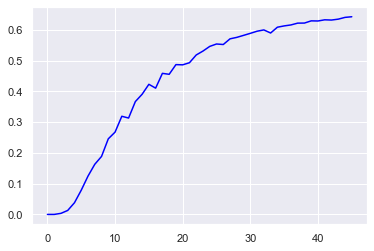

In [7]:
plt.plot(i_beta_12_04, color='blue')

In [8]:
scio.savemat('./i_beta_12_04.mat', {'i_beta_12_04': i_beta_12_04})